# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as rmse
import matplotlib.pyplot as plt

In [5]:
data_0 = pd.read_csv('../datasets/geo_data_0.csv')
data_1 = pd.read_csv('../datasets/geo_data_1.csv')
data_2 = pd.read_csv('../datasets/geo_data_2.csv')

In [6]:
data_0.shape[0], data_1.shape[0], data_2.shape[0]

(100000, 100000, 100000)

In [7]:
data_0['product'].nunique()

100000

In [8]:
data_1['product'].nunique()

12

In [9]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


## Обучение и проверка модели

In [11]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(
    data_0.drop(['id', 'product'], axis=1), 
    data_0['product'], 
    random_state=0
)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    data_1.drop(['id', 'product'], axis=1), 
    data_1['product'], 
    random_state=0
)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    data_2.drop(['id', 'product'], axis=1), 
    data_2['product'], 
    random_state=0
)

In [12]:
model_0 = LinearRegression().fit(X_train_0, y_train_0)
model_1 = LinearRegression().fit(X_train_1, y_train_1)
model_2 = LinearRegression().fit(X_train_2, y_train_2)

pred_0 = model_0.predict(X_test_0)
pred_1 = model_1.predict(X_test_1)
pred_2 = model_2.predict(X_test_2)

print(f'Средний запас предсказанного сырья для 0 региона: {pred_0.mean()}, RMSE: {rmse(y_test_0, pred_0)}')
print(f'Средний запас предсказанного сырья для 1 региона: {pred_1.mean()}, RMSE: {rmse(y_test_1, pred_1)}')
print(f'Средний запас предсказанного сырья для 2 региона: {pred_2.mean()}, RMSE: {rmse(y_test_2, pred_2)}')

Средний запас предсказанного сырья для 0 региона: 92.27144852242301, RMSE: 37.48100896950594
Средний запас предсказанного сырья для 1 региона: 69.15162398290752, RMSE: 0.8872573052219334
Средний запас предсказанного сырья для 2 региона: 94.70753129105672, RMSE: 40.31290686044374


## Подготовка к расчёту прибыли

In [120]:
budget = 10**10
income_per_unit = 450_000
sufficient_volume = budget / income_per_unit
sufficient_volume / 200

111.11111111111111

## Расчёт прибыли и рисков 

In [16]:
y_0 = pd.DataFrame({'target': y_test_0, 'predictions': pred_0})
y_1 = pd.DataFrame({'target': y_test_1, 'predictions': pred_1})
y_2 = pd.DataFrame({'target': y_test_2, 'predictions': pred_2})

In [17]:
y_0.sort_values(by='predictions', ascending=False)[:200].target.sum()

29696.462399128774

In [92]:
def profit_calculation(y):
    return y.sort_values(by='predictions', ascending=False)[:200].target.sum() * income_per_unit - budget

def get_profit_distr(y):
    return [profit_calculation(sample) for sample in (y.sample(500) for _ in range(1000))]

In [94]:
profit_distr_0 = get_profit_distr(y_0)
profit_distr_1 = get_profit_distr(y_1)
profit_distr_2 = get_profit_distr(y_2)

Регион 0
Средняя прибыль: 452678190.1829721
95% доверительный интервал: (-74848111.88005123, 981795453.265238)
Риск убытков: 0.044

Регион 1
Средняя прибыль: 470030613.870706
95% доверительный интервал: (73199223.7660636, 858100473.2780471)
Риск убытков: 0.009

Регион 2
Средняя прибыль: 386647512.06374806
95% доверительный интервал: (-142304375.35782957, 903540990.1753979)
Риск убытков: 0.068



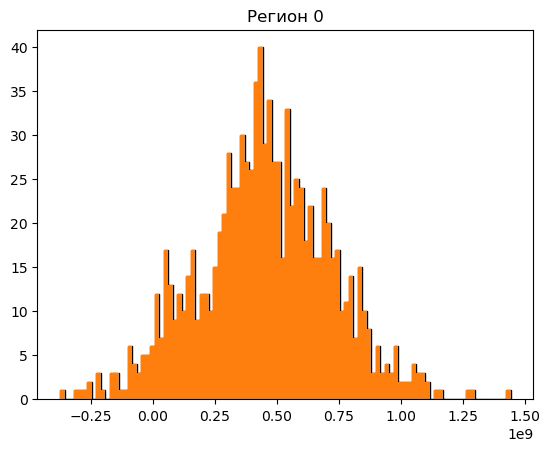

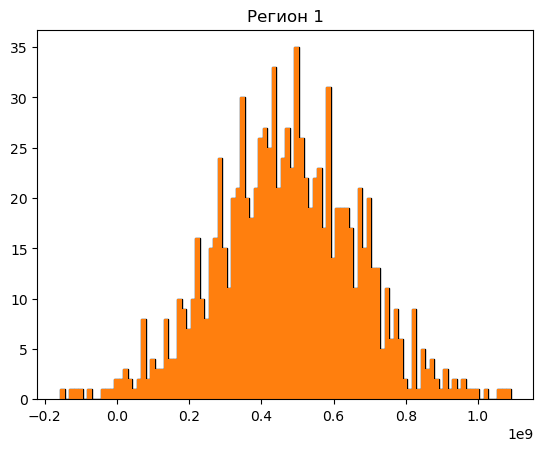

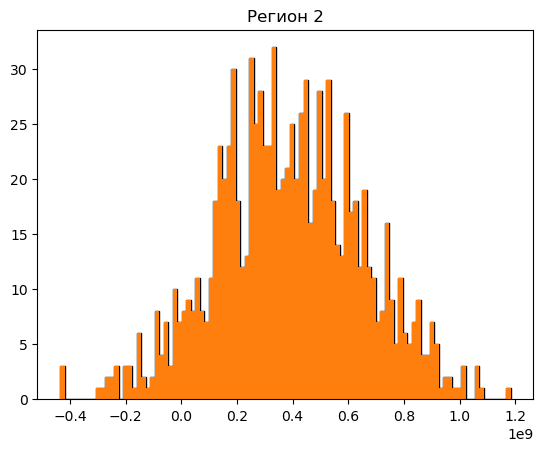

In [108]:
for i, profit in enumerate([profit_distr_0, profit_distr_1, profit_distr_2]):
    prof = pd.Series(profit)
    print(f'Регион {i}')
    print(f'Средняя прибыль: {prof.mean()}')
    print(f'95% доверительный интервал: {prof.quantile(0.025), prof.quantile(0.975)}')
    print(f'Риск убытков: {(prof < 0).sum() / len(prof)}\n')

    plt.figure()
    plt.hist(profit, bins=100, edgecolor='black')
    plt.title(f'Регион {i}')
    plt.hist(profit, bins=100)